# CH4 NOAA MLO Flask Data:  Cleaning and EDA 
**Data Source**: NOAA data (columns selected in `1_data_loading.ipynb`)  

## Key Notes  
- **Focus Gas**: CH₄ (Methane) - primary analysis target  
- **Data Quality**:  
  - Missing values: All rows kept (missing values → `NaN`)  
  - Negative values: Converted to `NaN` (non-physical concentrations)  
  - Data start dates: Gases have distinct collection start dates  
- Raw data pipeline documented in [`1_data_loading.ipynb`](../notebooks/1_data_loading.ipynb)  

## Data Files  
- **Input**: `../data/processed/CH4_raw_dropped_cols.csv`  
- **Output**: `../data/processed/df_model.csv`

**Notes on df_model**
- the index is datetime
- df_model features are aggregated values to handle replicate observations per data collection/analysis date for modeling.
  - value: aggregated as the mean concentration
  - value_unc: aggregates as the mean uncertainty
  - qcflag: aggregated as the mode (most frequent) quality control flag
- the 'method' feature was not kept since I could not discern a quantitative difference in data quality between the P and S methods.

# Libraries

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import linregress, mannwhitneyu
from pathlib import Path
import os
from statsmodels.tsa.stattools import adfuller, kpss

# Make directory

In [2]:
# automatic path handling
NOTEBOOK_PATH = Path.cwd() # gets current working directory
if 'notebooks' in str(NOTEBOOK_PATH): # if running from /notebooks/
    PROCESSED_DATA = NOTEBOOK_PATH.parent / 'data' / 'processed'
else: # if running from the repo root
    PROCESSED_DATA = NOTEBOOK_PATH / 'data' / 'processed'

# create folder (if necessary)
PROCESSED_DATA.mkdir(parents=True, exist_ok=True)

# Load data

In [3]:
df = pd.read_csv('../data/processed/CH4_raw_dropped_cols.csv', index_col='date', parse_dates=True)

In [4]:
df.head()

,value,value_unc,qcflag,method
date,,,,
1983-05-06,1659.334,3.3,...,P
1983-05-06,1654.272,3.3,...,P
1983-05-13,1645.170,3.3,...,P
1983-05-20,1631.007,3.3,...,P
1983-05-20,1627.970,3.3,...,P


# EDA of raw data

## Data info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7162 entries, 1983-05-06 to 2024-12-31
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   value      7162 non-null   float64
 1   value_unc  7162 non-null   float64
 2   qcflag     7162 non-null   object 
 3   method     7162 non-null   object 
dtypes: float64(2), object(2)
memory usage: 279.8+ KB


In [6]:
df.describe()

,value,value_unc
count,7162.000000,7162.000000
mean,1800.274969,-1.412860
std,173.766963,55.444785
min,-999.990000,-999.999000
25%,1768.822500,0.910000
50%,1801.875000,1.400000
75%,1856.457500,2.050000
max,2191.190000,4.590000


value = -999.99 and value_unc = -999.999 are fill values and indicate missing data

## Date range

In [7]:
# overall range of DataFrame
date_min = df.index.min()
date_max = df.index.max()
print(f'Date range of CH4 data: {date_min.date()} - {date_max.date()}')

Date range of CH4 data: 1983-05-06 - 2024-12-31


## Data plot

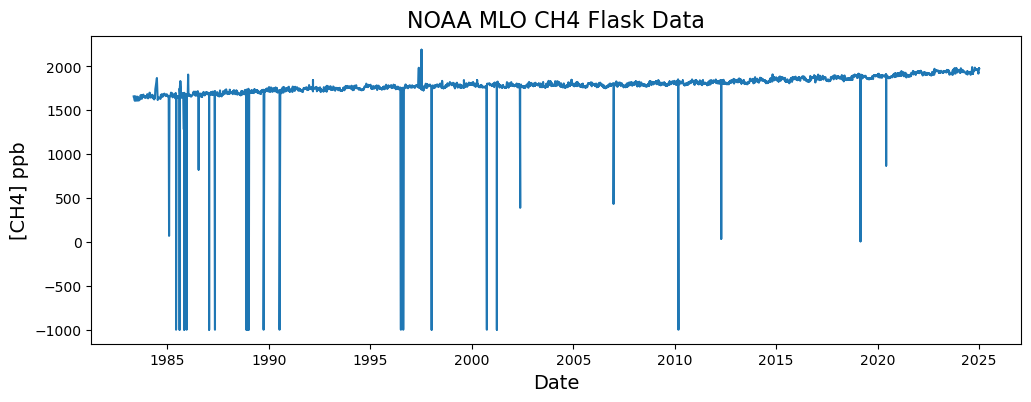

In [241]:
plt.figure(figsize=(12,4))
plt.plot(df.index, df['value'])
plt.title('NOAA MLO CH4 Flask Data', fontsize=16)
plt.ylabel('[CH4] ppb', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.show()

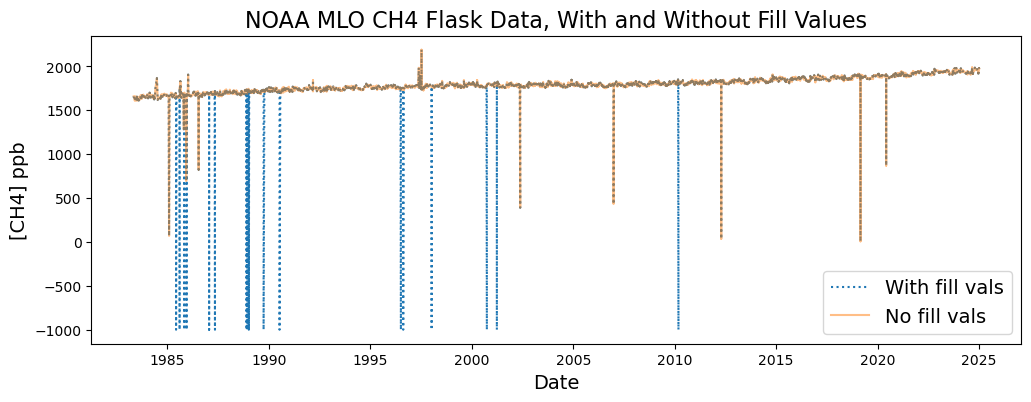

In [253]:
# plot the data without the fill values for comparison

df_noFillVal = df['value'].replace(-999.99, np.nan)

plt.figure(figsize=(12,4))
plt.plot(df.index, df['value'], linestyle='dotted', label='With fill vals')
plt.plot(df_noFillVal.index, df_noFillVal, alpha=0.5, label='No fill vals')
plt.title('NOAA MLO CH4 Flask Data, With and Without Fill Values', fontsize=16)
plt.ylabel('[CH4] ppb', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=14)
plt.show()

## value_unc (value uncertainty)

### Value set

In [88]:
value_unc_unique = df['value_unc'].unique()
print(list(np.sort(value_unc_unique)))

[-999.999, 0.575, 0.907, 0.91, 1.31, 1.4, 1.7, 1.87, 1.97, 2.05, 2.33, 2.4, 2.71, 3.3, 4.59]


The value_unc column has values in ppb (nmol/mol), which is the same unit as the CH4 gas concentration data, excpet for -999.999, which indicates a missing value.  

Based on the NOAA GML documentation covering standard/scale uncertainties (which states “standard uncertainty represents approximately 68% confidence level (1-sigma)”) and the fact that value_unc provides per-sample uncertainty values (ref1), I interpret value_unc to represent a 1-sigma (68% confidence) uncertainty on the measured CH4 value. However, this is an inference since I was not able to locate a documentation entry in the file README that explicitly describes it in those exact words.  

1 sigma of the measurement process is the estimated uncertainty, i.e. if the same air sample (flask) were analyzed repeatedly under the same conditions, we’d expect the measured CH4 concentration to fall within +/- value_unc of the reported value about 68% of the time.  So, a value-unc = 0.575 means that the measured CH4 value has an uncertainty of +/- 0.575 ppb, which is much more precise than a value_unc = 4.59 ppb. 

Xin Lan, et al report that:
"Analytical repeatability, or short-term measurement noise (sometimes called precision), is assessed through a number of methods, but most commonly as the standard deviation of the mean of multiple measurements of natural air from a cylinder. It varies with analytical instruments from 0.3 to 2.3 ppb (all uncertainties are given as 68% confidence intervals)." (ref2).  **Therefore, I will initially flag data with value_unc > 3 (ppb) for possible exclusion or down-weighting in the model.**  

- ref1: https://gml.noaa.gov/ccl/ccl_uncertainties.html
- ref2: https://gml.noaa.gov/ccgg/arc/?id=166

### Inspect value_unc fill values (-999.999)

In [87]:
# make sure that there are no missing value_unc values
print(f'Number of missing value_unc values: {df['value_unc'].isna().sum()}')

# count the number of value_unc == -999.999 (fill values indicating missing data)
print(f'Number of value_unc == -999.999: {(df['value_unc'] == -999.999).sum()}')

Number of missing value_unc values: 0
Number of value_unc == -999.999: 22


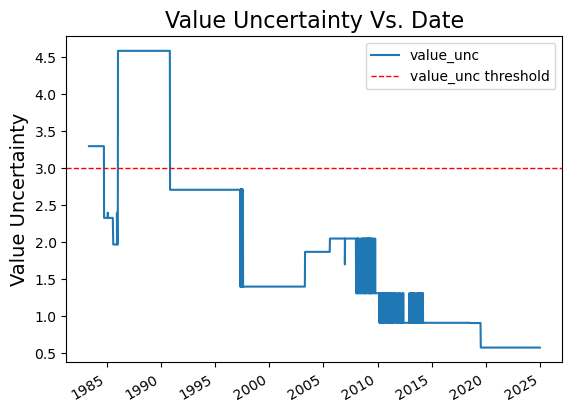

In [57]:
# plot the value_unc values vs date to investigate any trend.  The references suggest that the data collection
# and retrieval methods have improved over time.  So, the expectation is to see lower value uncertainty over time. 

filtered_df = df[df['value_unc'] != -999.999]      
filtered_df.plot(y='value_unc')
plt.title('Value Uncertainty Vs. Date', fontsize=16)
plt.ylabel('Value Uncertainty', fontsize=14)
plt.xlabel('')
plt.axhline(y=3.0, color='r', linestyle='--', linewidth=1, label='value_unc threshold')
plt.legend()
plt.show()

There is definitely a trend for decreasing value uncertainty.  Most data with value_unc < 3 are after 1990.  The plot reflects progressive improvement in CH4 measurement precission due to advances in analyzers, calibration standards, handling, etc.  

### Flag value_unc > 3 ppb

In [13]:
df['unc_flag'] = df['value_unc'] > 3
df

,value,value_unc,qcflag,method,unc_flag
date,,,,,
1983-05-06,1659.334,3.300,...,P,True
1983-05-06,1654.272,3.300,...,P,True
1983-05-13,1645.170,3.300,...,P,True
1983-05-20,1631.007,3.300,...,P,True
1983-05-20,1627.970,3.300,...,P,True
...,...,...,...,...,...
2024-12-24,1954.760,0.575,...,S,False
2024-12-31,1975.490,0.575,.S.,P,False
2024-12-31,1974.960,0.575,.S.,P,False


In [14]:
# get a count of rows where value_unc > 3

total_value_unc_3plus = (df['unc_flag'] == True).sum()
print(f'Number of observations where value_unc > 3: {total_value_unc_3plus}')
print(f'Percent of data with value_unc > 3: {(total_value_unc_3plus / len(df)) * 100:.2f}%')

Number of observations where value_unc > 3: 682
Percent of data with value_unc > 3: 9.52%


## qcflag (quality control flags)

- **qcflag column**: 3-character flags to indicate retained or rejected flask results as follows:

If the first character is not a period, the sample result should be
rejected for scientific use due to sample collection and/or measurement
issues. A second column character other than a period indicates a sample
that has no identifiable measurement or sampling errors but does not meet selection for representativeness
such as midday sampling or background air sampling or is otherwise atypical for a given sampling location and season. A third column flag
other than a period indicates noteworthy circumstances that are not known
to affect the data quality, but may have potential to.

| Indication | Flag | Description |
|------------|------|-------------|
| Retained |        ... |     good pair, no other issues |
| Retained |        ..* |     good pair, no definitive issues |
| Rejected |        M.. |     sample measurement issue |
| Rejected |        C.. |     sample collection issue |
| Rejected |        B.. |     both measurement and collection issues |
| Selection |       .S. |     selection issue. High/low mole fraction thought to not represent background conditions for example. |
| Informational |   ..M |     informational measurement tag or potential measurement issue |
| Informational |   ..C |     informational collection tag or potential collection issue |

- The information above is taken directly from the CH4 data [README](https://gml.noaa.gov/aftp/data/trace_gases/ch4/flask/surface/README_ch4_surface-flask_ccgg.html)
- Observations with QCFlags marked as M.., C.., or B.. will need to be either removed or the CH4 concentration values converted to NaN.  I will flag the selection and informational flagged values (.S., ..M, as "qcflagged".

### Value counts

In [33]:
# overview of qcflag value counts

df['qcflag'].value_counts()

qcflag
...    7015
C..      52
M..      35
.S.      32
..C      15
..M      13
Name: count, dtype: int64

In [39]:
# count the number of rejected observations, 
# any qcflag value where the first character of the string is not a period ('.').

rejected_obs = df['qcflag'].str[0] != '.'
print(f'Number of observations rejected based on QCFlag: {rejected_obs.sum()}')
print(f'Percent of rejected observations in the dataset: {(rejected_obs.sum() / len(df)) * 100:.2f}%')

Number of observations rejected based on QCFlag: 87
Percent of rejected observations in the dataset: 1.21%


### Rejected observation value uncertainty

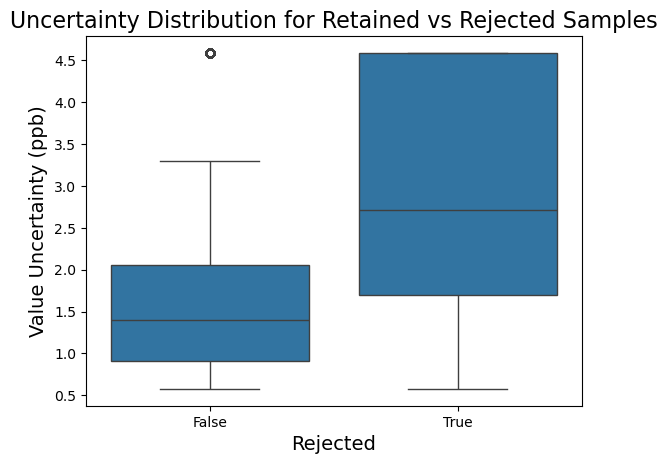

In [161]:
# explore any correlation between rejected observations and value_unc values

df['rejected'] = df['qcflag'].isin(['M..', 'C..', 'B..'])

sns.boxplot(x='rejected', y='value_unc', data=filtered_df)
plt.title('Uncertainty Distribution for Retained vs Rejected Samples', fontsize=16)
plt.ylabel('Value Uncertainty (ppb)', fontsize=14)
plt.xlabel('Rejected', fontsize=14)
plt.show()

In [165]:
filtered_df.groupby('rejected')['value_unc'].describe()

,count,mean,std,min,25%,50%,75%,max
rejected,,,,,,,,
False,7075.0,1.652608,1.072666,0.575,0.91,1.40,2.05,4.59
True,65.0,2.905769,1.439971,0.575,1.70,2.71,4.59,4.59


In [166]:
# run the (nonparametric) Mann-Whitney U test to determine if the rejected group's uncertainties are greater than those of the retained observations.
# H0 = no difference between two groups being compared

rejected = filtered_df.loc[filtered_df['rejected'], 'value_unc']
retained = filtered_df.loc[~filtered_df['rejected'], 'value_unc']

u_stat, p_value = mannwhitneyu(rejected, retained, alternative='greater')
print(f'Mann-Whitney U test p-value: {p_value:.4e}')

Mann-Whitney U test p-value: 2.0081e-13


The Mann-Whitney U test rejectes the null hypothesis that there is no difference between the groups.  Therefore, rejected observations have a greater mean value uncertainty.

### Rejected observations by date

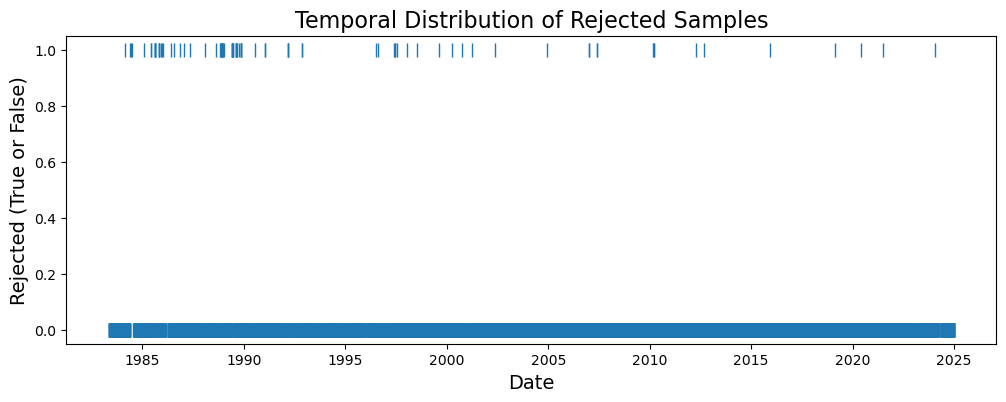

In [48]:
# determine if rejected observations are clustered by date

plt.figure(figsize=(12,4))
plt.plot(df.index, df['rejected'], '|', markersize=10)
plt.title('Temporal Distribution of Rejected Samples', fontsize=16)
plt.ylabel('Rejected (True or False)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.show()

Rejected samples (qcflag = True) exhibit significantly higher reported measurement uncertainties (value_unc), on average, compared to retained samples.  The median uncertainty for rejected samples (~2.7 ppb) is nearly twice that of retained samples (~1.40 ppb), and the upper quartile for rejected data extends to the max observed value uncertainty (4.59 ppb). A Mann-Whitney U test confirms that the difference is statistically significant (p << 0.05).  
Also, early timepoints (pre-1995) have a greater clustering of rejected values compared to any period after 1995.  This is consistent with the value_unc vs date plot above, which shows that the observations with the greatest uncertainty are those that were collected prior to 1995. Both observations reflect methodological and equipment improvements by NOAA scientists and engineers over time.  

Exlusion of the "rejected" data is justified based on NOAA's documentation and analysis here.  Additionally, modeling and forecasting focused on data collected after ~1990 - 1995 will likely produce better model parameter estimates and narrower forecasting confidence intervals.

## method (collection methods)

### Types used for CH4 collection

In [99]:
method_types = df['method'].unique()
print(f'Method types used for CH4 gas collection: {method_types}')

Method types used for CH4 gas collection: ['P' 'S']


**method column**: single-character code used to identify the sample collection method.  The methods listed below is a subset of method types used by NOAA at MLO.  See dataset [README](https://gml.noaa.gov/aftp/data/trace_gases/ch4/flask/surface/README_ch4_surface-flask_ccgg.html)

| Code | Description |
|------|-------------|
| P |Sample collected using a portable, battery powered pumping unit.  Two flasks are connected in series, flushed with air, and then pressurized to 1.2 - 1.5 times ambient pressure. |
| S | Flasks filled at NOAA GML observatories by sampling air from the in situ CO2 measurement air intake system. |

In [100]:
for m in method_types:
    print(f'Number of observations by "{m}": {(df['method']==m).sum()}')

Number of observations by "P": 4365
Number of observations by "S": 2797


### Collection methods over time

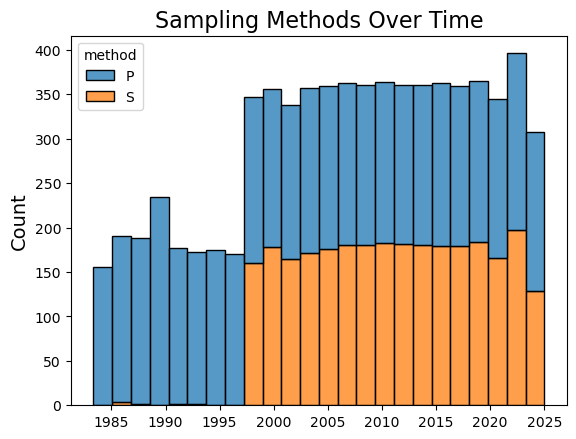

In [68]:
# determine if one sampling method was phased out or introduced at a certain time

sns.histplot(data=df, x='date', hue='method', multiple='stack')
plt.title('Sampling Methods Over Time', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('')
plt.show()

While the P method dominated prior to ~1997, Both S and P methods were used with comparable frequency after ~1997.

### Value uncertainty vs. collection method 

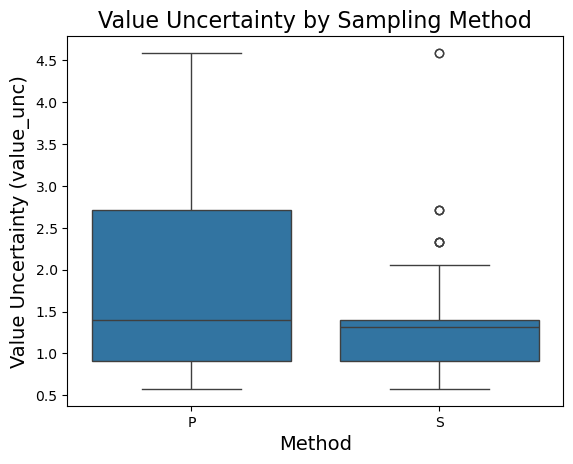

In [167]:
# check for correlation of value uncertainty vs data collection method

sns.boxplot(x='method', y='value_unc', data=filtered_df)
plt.title('Value Uncertainty by Sampling Method', fontsize=16)
plt.ylabel('Value Uncertainty (value_unc)', fontsize=14)
plt.xlabel('Method', fontsize=14)
plt.show()

In [168]:
filtered_df.groupby('method')['value_unc'].describe()

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
P,4346.0,1.953617,1.248656,0.575,0.91,1.40,2.71,4.59
S,2794.0,1.213550,0.488812,0.575,0.91,1.31,1.40,4.59


The "P" Method generally has higher and a more variable distribution of uncertainty values compared with the "S" method. Although the mean values of each are similar, the "S" method seems to be more reliable with regards to value uncertainty.  Therefore, a conclusion is that the "S" method is more reliable in producing fewer quality control rejections.  

In [109]:
method_crosstab = pd.crosstab(df['method'], df['rejected'])

method_crosstab['percent_rejected'] = (
    method_crosstab[True] / method_crosstab.sum(axis=1) * 100
)

method_crosstab['percent_rejected'] = method_crosstab['percent_rejected'].round(2)
method_crosstab

rejected,False,True,percent_rejected
method,,,
P,4294,71,1.63
S,2781,16,0.57


The "P" collection method has a rejection rate that is nearly 3x that of the "S" collection method.  

However, I have shown that all observation with value uncertainty > 3 ppb are pre-1995, a substantial cluster of rejected samples are pre-1995, and data collected pre-1997 was predominantly by method "P".  To more rigorously assess observation rejection based on collection method, I will limit the crosstabulation to data starting on 1997. 

df_post97 dates range from 1997-01-03 00:00:00 to 2024-12-31 00:00:00



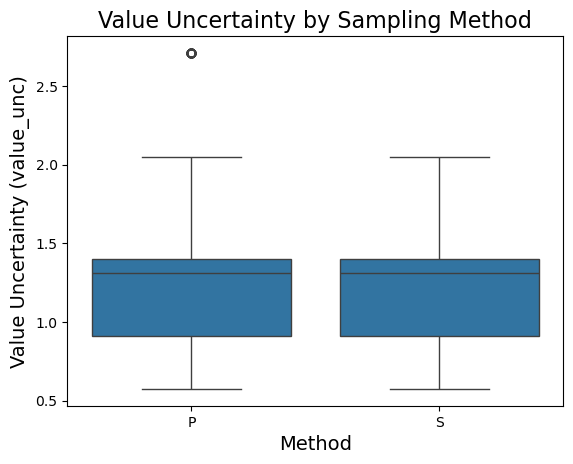

In [172]:
# check for correlation of value uncertainty vs collection method in post-1997 data

# filter for data after 1997
df_post97 = filtered_df[filtered_df.index >= '1997-01-01']

# verify df_post97 data range
print(f'df_post97 dates range from {df_post97.index[0]} to {df_post97.index[-1]}\n')

sns.boxplot(x='method', y='value_unc', data=df_post97)
plt.title('Value Uncertainty by Sampling Method', fontsize=16)
plt.ylabel('Value Uncertainty (value_unc)', fontsize=14)
plt.xlabel('Method', fontsize=14)
plt.show()

In [171]:
df_post97.groupby('method')['value_unc'].describe()

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
P,2931.0,1.229283,0.521208,0.575,0.91,1.31,1.4,2.71
S,2785.0,1.207910,0.476743,0.575,0.91,1.31,1.4,2.05


In [176]:
# run the (nonparametric) Mann-Whitney U test to determine if the small difference in 
# mean valun_unc between data collection methods is statistically signifcant.  
# H0: the distributions of value_unc for methods P and S are the same.

P = df_post97.loc[df_post97['method'] == 'P', 'value_unc']
S = df_post97.loc[df_post97['method'] == 'S', 'value_unc']

u_stat, p_value = mannwhitneyu(P, S, alternative='two-sided') # use 'two-sided' here since it isn't important which method may be greater
print(f'Mann-Whitney U test p-value: {p_value:.4e}')

Mann-Whitney U test p-value: 5.7804e-01


In [114]:
method_crosstab_post97 = pd.crosstab(df_post97['method'], df_post97['rejected'])

method_crosstab_post97['percent_rejected'] = (
    method_crosstab_post97[True] / method_crosstab_post97.sum(axis=1) * 100
)

method_crosstab_post97['percent_rejected'] = method_crosstab_post97['percent_rejected'].round(2)
method_crosstab_post97

df_post97 dates range from 1997-01-03 00:00:00 to 2024-12-31 00:00:00



rejected,False,True,percent_rejected
method,,,
P,2922,11,0.38
S,2773,15,0.54


To control for temporal confounding, rejection rates were recalculated for observations collected after 1997, when both "P" and "S" methods were routinely employed.

The rejection rates converge to 0.38% (P) and 0.54% (S), indicating that the earlier observed discrepancy (1.63% vs 0.57%) was largely driven by pre-1995 data, when the "P" method dominated and a higher proportion of measurements were rejected.  Furthermore, a Mann-Whitney U test fails to reject the null hypothesis that the distributions of value_unc for methods P and S are the same.

This suggests that method-specific differences in rejection rates are negligible under modern sampling and quality control procedures.

## value ([CH4] ppb)

In [126]:
# inspect the number of missing and fill values for the value feature and compare with value_unc results
print(f"Number of df['value'] null values: {df['value'].isna().sum()}")
print(f"Number of df['value'] fill values: {(df['value'] == -999.99).sum()}")
print(f"Number of df['value_unc'] fill values: {(df['value_unc'] == -999.999).sum()}")

Number of df['value'] null values: 0
Number of df['value'] fill values: 21
Number of df['value_unc'] fill values: 22


There is one observation where value_unc == -999.999 and the value != -999.99.  I will inspect that row of data.

In [125]:
mask_mismatch = (df['value_unc'] == -999.999) & (df['value'] != -999.99)
mismatched_rows = df[mask_mismatch]

mismatched_rows

,value,value_unc,qcflag,method,unc_flag,rejected
date,,,,,,
2019-02-26,7.48,-999.999,M..,P,False,True


The single row of data with mismatched fill values for value_unc and value features is flagged as rejected.  This observation will be dropped or the value will be replaced with NaN for imputation during preprocessing in the subsequent notebook.   

# Data cleaning

I will drop observations where:
- qcflag == "M..", ""C..", "B.." (rejected = True)
- value_unc > 3 (unc_flag = True) or == -999.999

All remaining observations should have valid values for "value".  

## Drop observations

In [127]:
# filter
rejected_flags = ['M..', 'C..', 'B..']

# drop observations
df_clean = df[
    (~df['qcflag'].isin(rejected_flags)) &
    (df['value_unc'] <= 3) & 
    (~df['value_unc'].isin([-999.999]))
]

In [128]:
df_clean[['value', 'value_unc']].isna().sum()

value        0
value_unc    0
dtype: int64

In [137]:
# calculate the sum of dropped values to verify that df_clean has the correct
# number of observations

drop_mask = (
    df['qcflag'].isin(rejected_flags)
    | (df['value_unc'] >= 3)
    | (df['value_unc'] == -999.999)
)

sum_drop = drop_mask.sum()
print('Dropped observations: ', sum_drop)
print('Remaining observations: ', len(df) - sum_drop)
print('Number of observations in df_clean: ', len(df_clean))

Dropped observations:  741
Remaining observations:  6421
Number of observations in df_clean:  6421


In [153]:
print('Number of value = -999.99: ', (df_clean['value'] == -999.99).sum())
print('Number of value_unc >= 3: ', (df_clean['value_unc'] >= 3).sum())
print('Number of value_unc == -999.999: ', (df_clean['value_unc'] == -999.999).sum())
print('Number of value_unc with "rejected_flags": ', (df_clean['qcflag'].isin(rejected_flags)).sum())

Number of value = -999.99:  0
Number of value_unc >= 3:  0
Number of value_unc == -999.999:  0
Number of value_unc with "rejected_flags":  0


## Drop engineered features 

In [156]:
# finally, verify that unc_flag and rejected values are all false.
# if so, I can drop those features/columns from df_clean

print('Number of unc_flag == True: ', (df_clean['unc_flag'] == True).sum())
print('Number of rejected == True: ', (df_clean['rejected'] == True).sum())

Number of unc_flag == True:  0
Number of rejected == True:  0


In [158]:
df_clean = df_clean.drop(columns=['unc_flag', 'rejected'])
df_clean.columns

Index(['value', 'value_unc', 'qcflag', 'method'], dtype='object')

In [159]:
df_clean.head()

,value,value_unc,qcflag,method
date,,,,
1984-09-28,1680.20,2.33,...,P
1984-09-28,1684.27,2.33,...,P
1984-10-05,1654.33,2.33,...,P
1984-10-05,1656.39,2.33,...,P
1984-10-12,1664.49,2.33,...,P


In [185]:
# compare observations per year for df_clean and df

# calculate yearly observation counts for each DataFrame.  
# use .resample('YE') to get the year end date since the index is datetime
# use .size() to get the counts
df_clean_yearly_counts = df_clean.resample('YE').size()
df_yearly_counts = df.resample('YE').size()

# combine into a single DataFrame
yearly_counts_comp = pd.concat([df_clean_yearly_counts, df_yearly_counts], axis=1)

# replace NaN values with 0
yearly_counts_comp = yearly_counts_comp.fillna(0)

# rename columns
yearly_counts_comp.columns = ['cleaned_df', 'original_df']

# calculate the difference
yearly_counts_comp['difference'] = yearly_counts_comp['original_df'] - yearly_counts_comp['cleaned_df']

# reset the index and set year as a column
yearly_counts_comp = yearly_counts_comp.reset_index()
yearly_counts_comp = yearly_counts_comp.rename(columns={'index': 'date'})

yearly_counts_comp

,date,cleaned_df,original_df,difference
0,1983-12-31,0.0,63,63.0
1,1984-12-31,24.0,87,63.0
2,1985-12-31,88.0,101,13.0
3,1986-12-31,4.0,117,113.0
4,1987-12-31,0.0,113,113.0
5,1988-12-31,0.0,112,112.0
6,1989-12-31,0.0,139,139.0
7,1990-12-31,16.0,106,90.0
8,1991-12-31,106.0,108,2.0
9,1992-12-31,93.0,98,5.0


Data cleaning leaves a small sample or no data for years 1983 - 1990.  So, I will create a new dataframe that ranges from 1991-01-01 - 2024-12-31.  

First I need to handle the multiple (replicate) values per collection date.  The data collection is weekly but replicate samples are assayed either from the same flask or different flasks (indicated by container_id in the full dataset).  

## Aggregate the mean of sample values per collection date

In [189]:
# aggregate value and value_unc as the mean per collection date
# aggregate qcflag as the mode per collection date

df_weekly = (
    df_clean.groupby(df_clean.index.date)
    .agg({
        'value': 'mean',
        'value_unc': 'mean',
        'qcflag': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
    })
)

# convert the index back to datetime
df_weekly.index = pd.to_datetime(df_weekly.index)

df_weekly.head()

,value,value_unc,qcflag
1984-09-28,1682.235,2.33,...
1984-10-05,1655.360,2.33,...
1984-10-12,1666.205,2.33,...
1984-10-19,1663.325,2.33,...
1984-10-26,1682.640,2.33,...


In [219]:
# verify that aggregation is consistent with weekly data

print('Before grouping:', len(df_clean))

# calculate how many collection dates had multiple samples
date_counts = df_clean.groupby(df_clean.index.date).size()
print('Dates with >1 sample:', (date_counts > 1).sum())

print('After grouping:', len(df_weekly))
print(f'Aggregated data / 52 weeks per year: {len(df_weekly)/52:.2f} years')
print(f'2025 - 1991: {2025-1991} years')

Before grouping: 6421
Dates with >1 sample: 1790
After grouping: 1810
Aggregated data / 52 weeks per year: 34.81 years
2025 - 1991: 34 years


- NOAA reports multiple sample values per data collection date.  Nearly every collection date has more than one sample observations.  

- The number of data collections per year is consistent with weekly data (52 data collections per year)

## Create data subset for modeling

In [191]:
df_model = df_weekly[df_weekly.index >= '1991-01-01']
df_model.head()

,value,value_unc,qcflag
1991-01-04,1719.845,2.71,...
1991-01-11,1736.940,2.71,...
1991-01-18,1728.335,2.71,...
1991-01-25,1716.080,2.71,...
1991-02-01,1727.430,2.71,...


In [193]:
# check the full range of the data subset

print(f'df_model date range: {df_model.index.min()} to {df_model.index.max()}')

df_model date range: 1991-01-04 00:00:00 to 2024-12-31 00:00:00


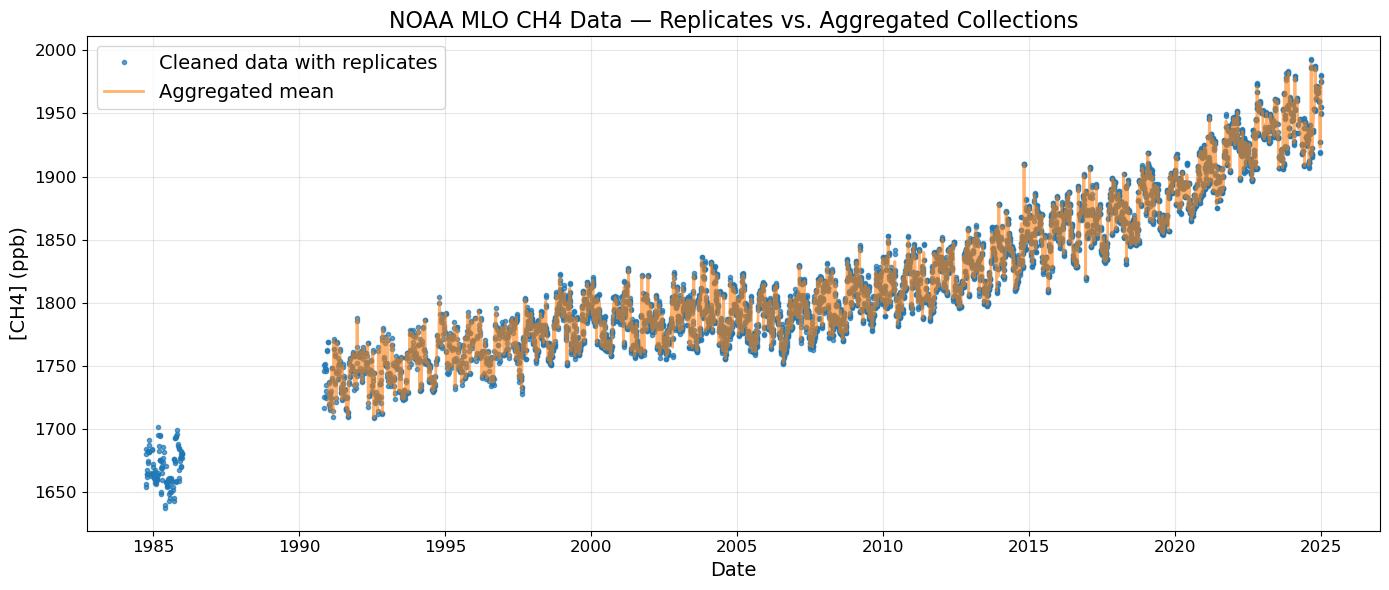

In [254]:
# check if the aggregated data follows the same trend and seasonality as the cleaned data with replicates

plt.figure(figsize=(14, 6))

# Plot original replicate-level data (semi-transparent)
plt.plot(df_clean.index, df_clean['value'], 
         'o', markersize=3, alpha=0.7, label='Cleaned data with replicates')

# Plot aggregated collection-level data
plt.plot(df_model.index, df_model['value'], 
         '-', linewidth=2, alpha=0.6, label='Aggregated mean')

plt.title('NOAA MLO CH4 Data — Replicates vs. Aggregated Collections', fontsize=16)
plt.ylabel('[CH4] (ppb)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Raw data EDA  and cleaning conclusions

- CH4 data prior to mid-1990s is problematic in that elevated value uncertainty predominated (value_unc >= 3) and also contains a substantial density of observations that are flagged for rejection (qcflag = "M..", ""C..", "B..").
- Data collection methods changed during this same time period from predcominately "P" to nearly equal use of "P" and "S".  Analysis of rejected data post-1997 rejects the hypothesis that the data collection method was a significant factor for higher value uncertanity or data flagged for rejection.
- Observations with the following feature values were dropped:
  - qcflag == "M..", ""C..", "B.."
  - value_unc >= 3
  - value_unc == -999.999
- 741 observations were dropped out of a total of 7162. 6421 observations remain.  
- There are no df['value'] values == -999.99 after dropping observations flagged for rejection or with value uncertainties >= 3 or == -999.999.
- After cleaning, the early years (1983-1990) have very few remaining observations.  Therefore the DataFrame for modeling will range from 1991-01-01 to 2021-12-31 (df_model).  
- The raw data contains multiple assays for CH4 concentration per flask (same container_id) or multiple sample collections from different flasks (different container_ids) per collection date.  I aggregated the mean value and value_unc and the qcflag mode by collection date.
- Data collection is weekly

# EDA on cleaned data

## determine the number of observations per year

In [314]:
df_counts = df_model.copy()

df_counts['year'] = df_counts.index.year
yearly_obs = df_counts.groupby('year').count()
yearly_obs

,value,value_unc,qcflag
year,,,
1991,52,52,52
1992,48,48,48
1993,51,51,51
1994,52,52,52
1995,50,50,50
1996,49,49,49
1997,50,50,50
1998,53,53,53
1999,51,51,51


In [316]:
# there is some variation, so will verify 52 observations per year by calculating the mode

seasonal_mode = yearly_obs.mode()
seasonal_mode

,value,value_unc,qcflag
0,52,52,52


The mode of observations in df_model is 52.  Therefore, there are ~52 observations per year.

## CH4 data trend

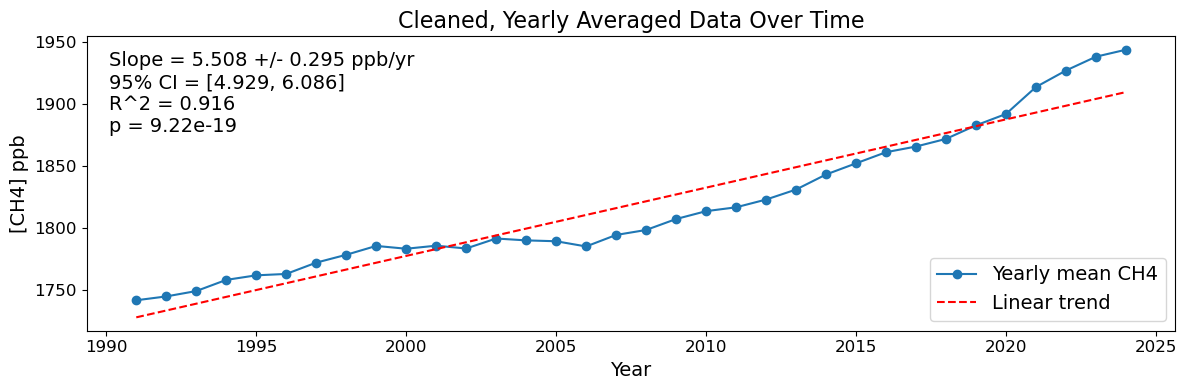

In [260]:
# calculate the yearly average
yearly_avg_df = df_model['value'].groupby(df_model.index.year).mean()

# calculate the slope
gas_trend_data = []

x = yearly_avg_df.index
y = yearly_avg_df

# linear regression
slope, intercept, r_value, p_value, std_err = linregress(x,y)

# predicted line
y_pred = intercept + slope * x

# confidence intervals
ci_lower = slope - 1.96 * std_err
ci_upper = slope + 1.96 * std_err

gas_trend_data_df = pd.DataFrame(gas_trend_data)

# plot the data
plt.figure(figsize=(12,4))
plt.plot(x, y, 'o-', label='Yearly mean CH4')
plt.plot(x, y_pred, 'r--', label='Linear trend')
plt.title('Cleaned, Yearly Averaged Data Over Time', fontsize=16)
plt.ylabel('[CH4] ppb', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# metrics text box
textstr = '\n'.join((
    f'Slope = {slope:.3f} +/- {std_err:.3f} ppb/yr',
    f'95% CI = [{ci_lower:.3f}, {ci_upper:.3f}]',
    f'R^2 = {r_value**2:.3f}',
    f'p = {p_value:.2e}'
))

# place box on the figure
plt.gca().text(
    0.02, 0.95, textstr, transform=plt.gca().transAxes,
    fontsize=14, verticalalignment='top',
    bbox=dict(boxstyle='square,pad=0.4', facecolor='white', edgecolor='none')
)

plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

- **Slope:**  CH4 concentration rose by 5.5 ppb/year over the ~34 years of data analyzed here [refs 1,2].
- **CI:** The CI (confidence interval) values suggest that the "true" annual increase is somewhere between 4.9 and 6.1 ppb/year.
- **R^2:** The R^2 value is strong and indicates that 91.6% of yearly variation is explained by the linear trend.
- **p:** The p-value indicates the probability of getting this slope by chance, which is extremely low.  

The plot of yearly averages show a stabiliation between approximately 2000 - 2007 [ref 3] and then an increase in rate around 2007 [refs 4,5]. 

refs 1, 2: According to NOAA GML (Trends in CH₄), annual increases in global atmospheric methane during the early 2010s were on the order of ~5 ppb/yr (e.g., 2010: +5.1 ppb, 2011: +5.0 ppb). This aligns well with our estimated slope of +5.508 ppb/yr. More broadly, decadal‐averaged growth rates have been ~3 ppb/yr in the 2000s and ~8.5 ppb/yr in the 2010s (Environment & Climate Change Canada, 2024).

- ref 1: https://gml.noaa.gov/ccgg/trends_ch4/?_hsmi=120270142&utm_source=chatgpt.com
- ref 2: https://www.canada.ca/en/environment-climate-change/services/environmental-indicators/greenhouse-gas-concentrations.html?utm_source=chatgpt.com

- ref 3: EJ Dlugokencky, et al., Atmospheric methane levels off: Temporary pause or a new steady-state? Geophys Res Lett 30, 1992 (2003).

- ref 4: M Rigby, et al., Renewed growth of atmospheric methane. Geophys Res Lett 35, L22805 (2008).

- ref 5: EJ Dlugokencky, et al., Observational constraints on recent increases in the atmospheric CH4 burden. Geophys Res Lett 36, L18803 (2009).

## CH4 seasonal cycles

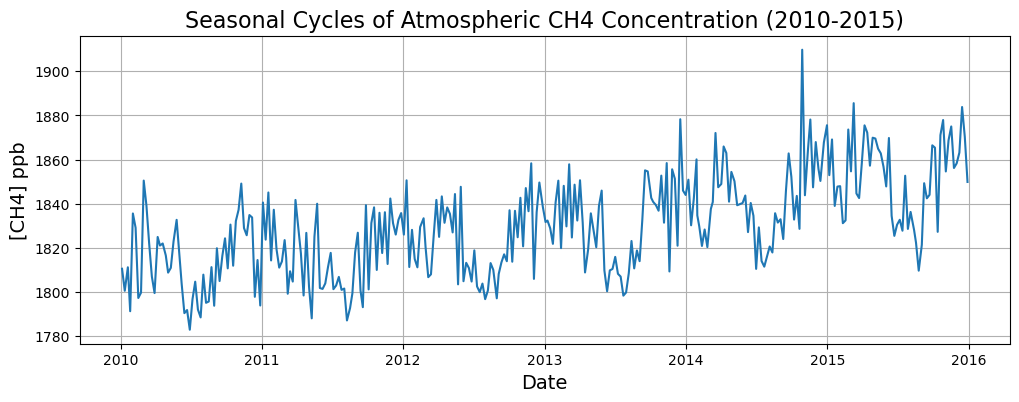

In [261]:
# create a subset of the data for visualization of the cycles
seasonal_window = df_model.loc['2010-01-01':'2015-12-31']

# plot
plt.figure(figsize=(12,4))
plt.plot(seasonal_window.index, seasonal_window['value'])
plt.title('Seasonal Cycles of Atmospheric CH4 Concentration (2010-2015)', fontsize=16)
plt.ylabel('[CH4] ppb', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True)
plt.show()

In [304]:
# I need to smooth the data to count peaks and troughs due to the sawtooth pattern.  

from scipy.signal import find_peaks

# 13-week (quarter-year) smoothing for weekly data
smoothed = seasonal_window['value'].rolling(window=13, center=True, min_periods=1).mean()

peaks, _ = find_peaks(smoothed, distance=26)   # distance to avoid counting nearby bumps
peak_dates = smoothed.index[peaks]
pd.Series(peak_dates).dt.year.value_counts().sort_index()

2010    2
2011    1
2012    1
2013    2
2014    1
2015    2
Name: count, dtype: int64

In [303]:
# count troughs   

y = smoothed.values

troughs, _ = find_peaks(-y, distance=26)   # distance to avoid counting nearby bumps
trough_dates = smoothed.index[troughs]
pd.Series(trough_dates).dt.year.value_counts().sort_index()

2010    1
2011    1
2012    1
2013    1
2014    1
2015    1
Name: count, dtype: int64

In [298]:
# mask potential edge effects to verify the results of one maine cycle per year

mask1015 = (smoothed.index >= '2010-06-01') & (smoothed.index <='2015-06-01')
smoothed_clip_1015 = smoothed[mask1015]

# Re-run peak/trough detection
peaks, _ = find_peaks(smoothed_clip_1015, distance=26)
troughs, _ = find_peaks(-smoothed_clip_1015, distance=26)

# Count per year again
peak_years = pd.Series(smoothed_clip_1015.index[peaks]).dt.year.value_counts().sort_index()
trough_years = pd.Series(smoothed_clip_1015.index[troughs]).dt.year.value_counts().sort_index()

print("Peaks per year:\n", peak_years)
print("\nTroughs per year:\n", trough_years)

Peaks per year:
 2010    1
2011    1
2012    1
2013    2
2014    1
2015    1
Name: count, dtype: int64

Troughs per year:
 2010    1
2011    1
2012    1
2013    2
2014    2
2015    1
Name: count, dtype: int64


The plot of CH4 concentration seasonal cycles from 2010-2015 shows clear annual cycles that are consistent with known seasonal patterns in atmospheric CH4 due to hydorxyl (OH-) oxidation, wetland emissions, and agricultural activities.  Mid-year troughs/valleys correspond to elevated atmospheric hydroxyl concentration resulting in reduced CH4 concentrations by oxidation. CH4 concentration peaks in late winter/early spring when hydroxyl concentration is low.  

In addition to the dominant annual cycle, semi-annual modulations may also occur, potentially linked to ENSO related variability in wetland CH4 emissions and other sources.  

**Summary of CH4 concentration trend and seasonality**

- Trend: ~5.5 ppb/year increase over 34 years of data analyzed (1991-2025)
- Seasonality: 1 dominant cycle per year with possible semi-annual modulations
- Data frequency: data collection is weekly and, therefore, each year and seaonal cycle has ~52 datapoints

# Save the df_model dataframe

In [323]:
# save df_model.csv to the GitHub folder "processed"

print(f'df_model is saved to {PROCESSED_DATA}')
df_model.to_csv(PROCESSED_DATA / 'df_model.csv', index=True)

df_model is saved to C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\data\processed


**Note**
- df_model as datetime as the index
- df_model features are aggregated values to handle replicate observations per data collection/analysis date for modeling.
    - value: aggregated as the mean concentration
    - value_unc: aggregates as the mean uncertainty
    - qcflag: aggregated as the mode (most frequent) quality control flag
- the 'method' feature was not kept since I could not discern a quantitative difference in data quality between the P and S methods.  

## Miscelaneous checks prior to loading df_model.csv into the 3_ch4_preprocessing notebook

In [324]:
print(f'number of missing values for value {df_model['value'].isna().sum()}')
print(f'number of missing values for value_unc {df_model['value_unc'].isna().sum()}')
print(f'number of missing values for qcflag {df_model['qcflag'].isna().sum()}')

number of missing values for value 0
number of missing values for value_unc 0
number of missing values for qcflag 0


In [325]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1746 entries, 1991-01-04 to 2024-12-31
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   value      1746 non-null   float64
 1   value_unc  1746 non-null   float64
 2   qcflag     1746 non-null   object 
dtypes: float64(2), object(1)
memory usage: 119.1+ KB


In [326]:
df_model.index.dtype

dtype('<M8[ns]')

In [327]:
df_model.head()

,value,value_unc,qcflag
1991-01-04,1719.845,2.71,...
1991-01-11,1736.940,2.71,...
1991-01-18,1728.335,2.71,...
1991-01-25,1716.080,2.71,...
1991-02-01,1727.430,2.71,...
